<a href="https://colab.research.google.com/github/choki0715/lecture/blob/master/seq2seq_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Multivariate Multistep Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras 
copyright to Blongathon

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

Downloading the dataset

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

--2022-05-05 05:32:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/x-httpd-php]
Saving to: ‘household_power_consumption.zip.1’

household_power_con 100%[===================>]  19.68M  29.7MB/s    in 0.7s    

2022-05-05 05:32:48 (29.7 MB/s) - ‘household_power_consumption.zip.1’ saved [20640916/20640916]



In [3]:
!unzip household_power_consumption.zip  

Archive:  household_power_consumption.zip
replace household_power_consumption.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Text to CSV**

In [4]:
df=pd.read_csv('household_power_consumption.zip', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


**Imputing Null values**

In [5]:
df = df.replace('?', np.nan)
df.isnull().sum()



Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [6]:
def fill_missing(values):
    one_day = 60*24
    cnt = 0  # ejk
    for row in range(df.shape[0]):
        num_nan = 0
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_day,col]
                num_nan +=1 # ejk
        if num_nan >= 7: # ejk
            cnt += 1 # ejk
    print('# of all nan row', cnt) # ejk 

df = df.astype('float32')
fill_missing(df.values)
df.isnull().sum()

# of all nan row 25979


Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Downsampling of Data from minutes to Days 

In [7]:
daily_df = df.resample('D').sum()
daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [8]:
daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [9]:
daily_df.shape, df.shape

((1442, 7), (2075259, 7))

In [10]:
# For this case, let's assume that
# Given past 10 days observation, forecast the next 5 days observations. 
n_past = 10
n_future = 5 
n_features = 7

Train - Test Split

In [11]:
train_df,test_df = daily_df[1:1081], daily_df[1081:]  # 75% and 25%
train_df.shape,test_df.shape

((1080, 7), (361, 7))

Scaling the values for faster training of the models.

In [12]:

scalers={}

train = train_df
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s = np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

**Converting the series to samples for supervised learning**

In [13]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [14]:
# Train 데이터를 입력 데이터와 레이블로 구분
X_train, y_train = split_series(train.values,n_past, n_future)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

# Test 데이터를 입력 데이터와 레이블로 구분
X_test, y_test = split_series(test.values,n_past, n_future)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [15]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1066, 10, 7) (347, 10, 7)
(1066, 5, 7) (347, 5, 7)


**Model Architecture**

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer. 

E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers. 

In [16]:
# E1D1: Encoder LSTM 1층, Decoder LSTM 1층 모델
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        43200       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 5, 100)       0           ['lstm[0][0]']                   
                                                                                              

In [17]:
# E2D2: Encoder LSTM 2층, Decoder LSTM 2층 모델
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10, 7)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 10, 100),    43200       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_3 (LSTM)                  [(None, 100),        80400       ['lstm_2[0][0]']                 
                                 (None, 100),                                               

 **Training the models**


In [26]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=250,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=250,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

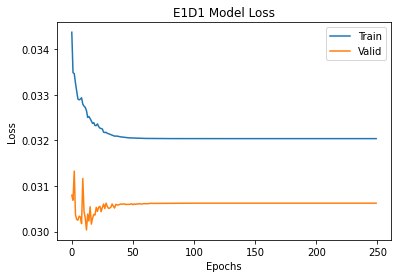

In [27]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

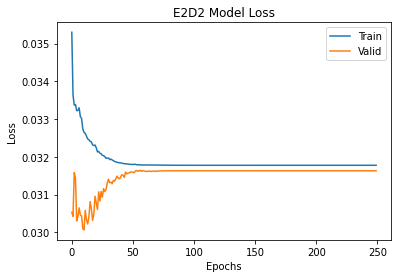

In [28]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

Prediction on validation set

In [32]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

pred_e1d1=model_e1d1.predict(X_train)
pred_e2d2=model_e2d2.predict(X_train)

print(X_test.shape, y_test.shape)
print(pred1_e1d1.shape, pred1_e2d2.shape)

(347, 10, 7) (347, 5, 7)
(347, 5, 7) (347, 5, 7)


Inverse Scaling of the predicted values

In [22]:
# convert to real value
'''
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    
    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])
'''

"\nfor index,i in enumerate(train_df.columns):\n    scaler = scalers['scaler_'+i]\n    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])\n    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])\n    \n    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])\n    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])\n    \n    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])\n    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])\n"

**Checking Error** 

From the above output we can observe that in some cases E2D2 model has 
performed better than E1D1 model with less error. Training different models with different number of stacked layers and creating an ensemble model also performs well. 

Note: The results vary with respect to the dataset. If we stack more layers it may also lead to overfitting. So the no of layers to be stackes acts as a hyper parameter. 

In [45]:
# 분석결과 가시화를 위한 Plot 함수 결정
# 시간축 x 값 생성 
def build_time_steps(length):
  return list(range(-length, 0))

def result_plot(past, true_future, pred_future):
  plt.figure(figsize=(12, 6))
  num_in = build_time_steps(len(past))
  num_out = len(true_future)
  STEP = 1
  plt.plot(num_in, np.array(past), label='Past')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), label='True Future') #'b-',
           
  if pred_future.any():
    plt.plot(np.arange(num_out)/STEP, np.array(pred_future), label='Pred Future', linewidth=5) #'r-',
             
  plt.legend(loc='upper left')
  plt.show()

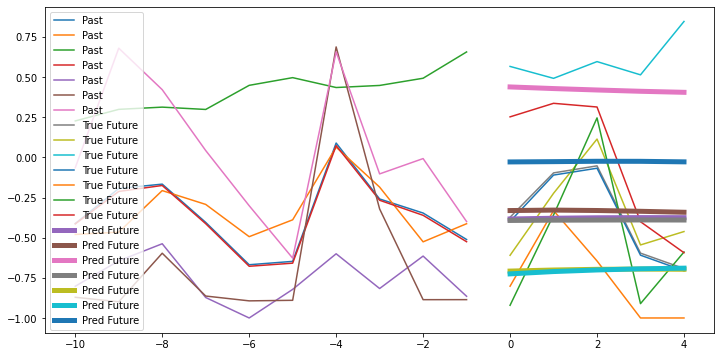

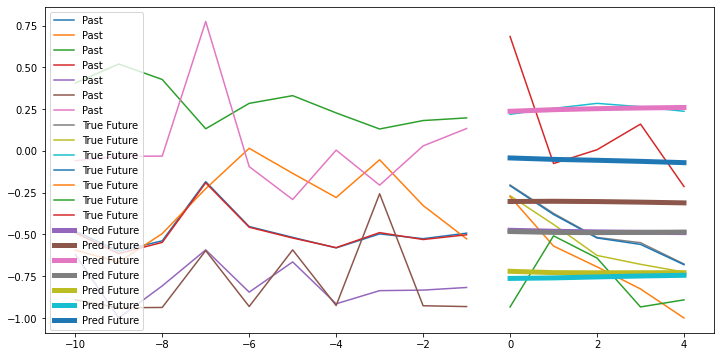

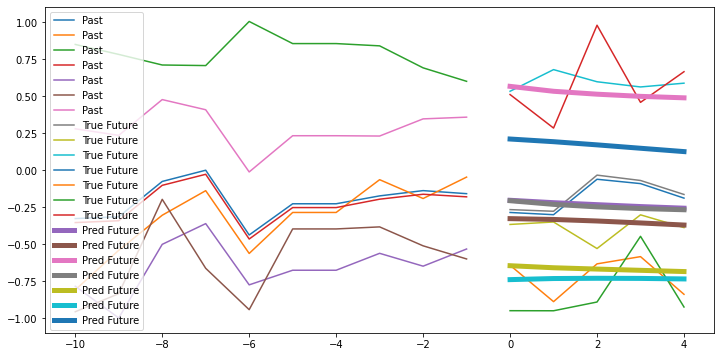

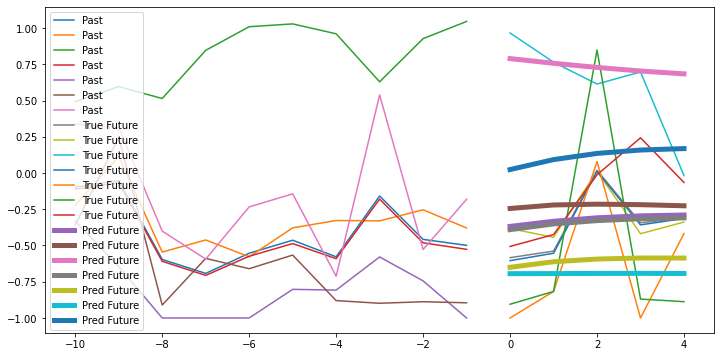

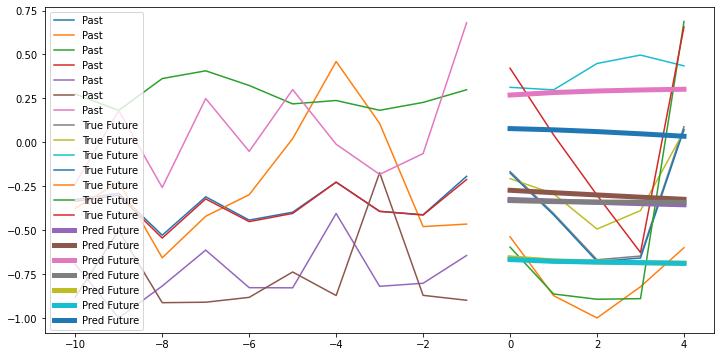

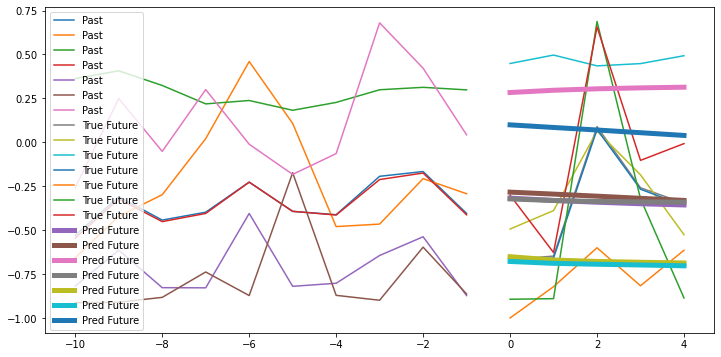

In [46]:
 
for i in range(6):
  index = np.random.randint(0,347)
  result_plot(X_test[index,:,:], y_test[index,:,:], pred1_e1d1[index,:,:] )
  
  
  